In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
import sqlite3
import shutil
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
stack = 'MD594'
section = 94
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [4]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'

savepath = 'CSHL_cells_mark/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

margin = 200/0.46

In [5]:
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

ALREADY DOWNLOADED FILE


In [6]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

ALREADY DOWNLOADED FILE


In [37]:
%%time
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = img / 255
count = 0
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    hsv = np.zeros([down-up, right-left, 3])
    hsv[:, :, 2] = img[up:down,left:right] / 255
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    for k in range(features_inside.shape[1]):
        x, y = CDF(features_inside[:,k])
        inside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        x, y = CDF(features_outside[:,k])
        outside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        diff = np.array(inside) - np.array(outside)
        if (np.absolute(diff)>0.1).sum()>0:
            values = np.array(thresholds[k])
            choose = set(values[np.absolute(diff)>0.1])
            for element in choose:
                posi = np.argmin(np.absolute(features_inside[:,k] - element))
                cx = int(locations_inside[posi, 0])
                cy = int(locations_inside[posi, 1])
                height = int(features_inside[posi, 11]/2)
                width = int(features_inside[posi, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 1.0
                
                nega = np.argmin(np.absolute(features_outside[:,k] - element))
                cx = int(locations_outside[nega, 0])
                cy = int(locations_outside[nega, 1])
                height = int(features_outside[nega, 11]/2)
                width = int(features_outside[nega, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 0.9
        else:
            continue

    count += 1
    print(section, structure, count, '/', len(polygons))

94 VCA 1 / 1
CPU times: user 19.7 s, sys: 470 ms, total: 20.2 s
Wall time: 7.21 s


In [42]:
bst.get_score(importance_type='cover')

{'f1078': 267.86319256,
 'f859': 279.25,
 'f99': 244.5,
 'f194': 34.75,
 'f1129': 215.270179696,
 'f404': 170.59101099999998,
 'f1354': 152.998825,
 'f1076': 329.439209,
 'f857': 149.81799785,
 'f198': 220.683823,
 'f197': 60.9856987,
 'f1156': 207.0561751425,
 'f1526': 192.794876,
 'f1744': 65.6670837,
 'f1077': 268.2307844,
 'f821': 247.366776,
 'f891': 199.20458200000002,
 'f1285': 21.5495224,
 'f1498': 164.92603309999998,
 'f1948': 196.239731,
 'f586': 63.1383743,
 'f1074': 257.58457455,
 'f58': 211.326469,
 'f1742': 21.1435509,
 'f402': 206.6785505,
 'f355': 106.12516,
 'f1079': 259.5979747,
 'f101': 210.420303,
 'f854': 175.480438,
 'f1731': 34.9398537,
 'f1980': 315.698746,
 'f1880': 191.469025725,
 'f211': 50.98184076666667,
 'f1081': 306.74843599999997,
 'f1286': 251.3299025,
 'f1734': 122.372749,
 'f98': 131.017822,
 'f960': 193.810425,
 'f138': 106.97828115,
 'f561': 162.482086,
 'f1502': 175.62465665,
 'f183': 39.7416954,
 'f1159': 256.8294105,
 'f178': 101.4750914,
 'f1351

In [44]:
bst.get_score(importance_type='gain')

{'f1078': 308.937612605,
 'f859': 99.6047974,
 'f99': 45.5374756,
 'f194': 21.7221107,
 'f1129': 27.457030969999998,
 'f404': 24.43962501,
 'f1354': 5.592085955,
 'f1076': 213.73691345,
 'f857': 39.120923265,
 'f198': 30.0174255,
 'f197': 38.9320869,
 'f1156': 12.49501884225,
 'f1526': 24.59525155,
 'f1744': 6.42362976,
 'f1077': 147.15094777000002,
 'f821': 44.208252,
 'f891': 22.7638245,
 'f1285': 14.1097841,
 'f1498': 17.724150644999998,
 'f1948': 29.3241158,
 'f586': 12.6259384,
 'f1074': 70.33937051750002,
 'f58': 21.918165199999997,
 'f1742': 16.6964703,
 'f402': 16.1806897,
 'f355': 11.7805176,
 'f1079': 75.83765793,
 'f101': 28.4589157,
 'f854': 16.4723358,
 'f1731': 18.1056118,
 'f1980': 21.202331075,
 'f1880': 26.704934590000004,
 'f211': 4.598669053333333,
 'f1081': 43.5843797025,
 'f1286': 32.83596035,
 'f1734': 40.4635582,
 'f98': 12.9634781,
 'f960': 30.5178299,
 'f138': 9.8423083925,
 'f561': 20.3443184,
 'f1502': 5.5683836837500005,
 'f183': 20.0303268,
 'f1159': 13.251

In [31]:
polygon[:, 0] = polygon[:, 0] - left
polygon[:, 1] = polygon[:, 1] - up

CPU times: user 358 ms, sys: 148 ms, total: 506 ms
Wall time: 507 ms


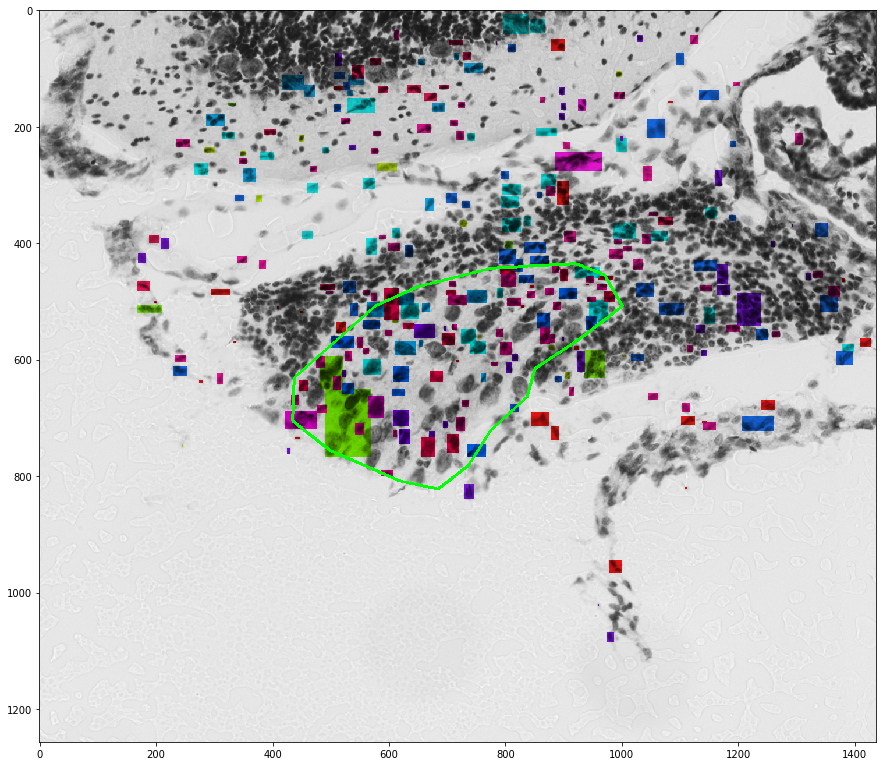

In [36]:
%%time
plt.figure(figsize=(15,15))
rgb = skimage.color.hsv2rgb(hsv)
rgb = rgb * 255
rgb = rgb.astype(np.uint8)
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com)

In [52]:
values = np.array(thresholds[k])
for element in set(values[np.absolute(diff)>0.1]):
    print(features_inside[np.argmin(np.absolute(features_inside[:,k] - element)),k], element)

15.0 15
16.0 16
17.0 17
18.0 18
18.0 19
20.0 20
21.0 21
22.0 22
23.0 23
24.0 24
26.0 25
26.0 26
27.0 27


In [51]:
features_inside.shape

(120, 20)